In [9]:
import torch

In [10]:
from torch_geometric.datasets import TUDataset

In [11]:
dataset = TUDataset(root='.', name='PROTEINS').shuffle()

print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of nodes: 14
Number of features: 3
Number of classes: 2


In [12]:
dataset[0].x

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [13]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Batch 0: DataBatch(edge_index=[2, 7362], x=[1978, 3], y=[64], batch=[1978], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 9310], x=[2485, 3], y=[64], batch=[2485], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 7780], x=[2111, 3], y=[64], batch=[2111], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 8934], x=[2515, 3], y=[64], batch=[2515], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 6936], x=[1857, 3], y=[64], batch=[1857], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 11856], x=[3062, 3], y=[64], batch=[3062], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 7700], x=[2044, 3], y=[64], batch=[2044], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 9554], x=[2520, 3], y=[64], batch=[2520], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 10062], x=[2705, 3], y=[64], batch=[2705], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 8110], x=[2160, 3], y=[64], batch=[2160], ptr=[65])
 - Batch 

In [22]:
import torch
torch.manual_seed(0)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, GATConv, GATv2Conv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1)

In [15]:
class GAT(torch.nn.Module):
    def __init__(self, dim_h):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, dim_h)
        self.conv2 = GATConv(dim_h, dim_h)
        self.conv3 = GATConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

In [37]:
class GATv2(torch.nn.Module):
    def __init__(self, dim_h):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(dataset.num_node_features, dim_h)
        self.conv2 = GATv2Conv(dim_h, dim_h)
        self.conv3 = GATv2Conv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

In [16]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader)

        # Print metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
            
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()



In [17]:
gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)
test_loss, test_acc = test(gcn, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print()

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print()

gat = GAT(dim_h=32)
gat = train(gat, train_loader)
test_loss, test_acc = test(gat, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.67 | Train Acc: 57.47% | Val Loss: 0.64 | Val Acc: 68.85%
Epoch  20 | Train Loss: 0.60 | Train Acc: 72.31% | Val Loss: 0.69 | Val Acc: 65.01%
Epoch  40 | Train Loss: 0.58 | Train Acc: 72.50% | Val Loss: 0.63 | Val Acc: 66.36%
Epoch  60 | Train Loss: 0.59 | Train Acc: 73.16% | Val Loss: 0.60 | Val Acc: 67.92%
Epoch  80 | Train Loss: 0.57 | Train Acc: 72.58% | Val Loss: 0.59 | Val Acc: 66.57%
Epoch 100 | Train Loss: 0.58 | Train Acc: 72.73% | Val Loss: 0.59 | Val Acc: 71.83%
Test Loss: 0.71 | Test Acc: 62.50%

Epoch   0 | Train Loss: 1.33 | Train Acc: 56.31% | Val Loss: 0.54 | Val Acc: 70.55%
Epoch  20 | Train Loss: 0.53 | Train Acc: 74.94% | Val Loss: 0.56 | Val Acc: 77.64%
Epoch  40 | Train Loss: 0.51 | Train Acc: 76.45% | Val Loss: 0.58 | Val Acc: 73.32%
Epoch  60 | Train Loss: 0.50 | Train Acc: 75.98% | Val Loss: 0.54 | Val Acc: 73.11%
Epoch  80 | Train Loss: 0.48 | Train Acc: 77.41% | Val Loss: 0.50 | Val Acc: 74.24%
Epoch 100 | Train Loss: 0.48 | Train Acc

In [38]:
gat = GATv2(dim_h=32)
gat = train(gat, train_loader)
test_loss, test_acc = test(gat, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.69 | Train Acc: 59.66% | Val Loss: 0.63 | Val Acc: 68.92%
Epoch  20 | Train Loss: 0.58 | Train Acc: 72.83% | Val Loss: 0.63 | Val Acc: 68.70%
Epoch  40 | Train Loss: 0.59 | Train Acc: 71.00% | Val Loss: 0.60 | Val Acc: 68.98%
Epoch  60 | Train Loss: 0.58 | Train Acc: 71.19% | Val Loss: 0.61 | Val Acc: 65.51%
Epoch  80 | Train Loss: 0.57 | Train Acc: 72.73% | Val Loss: 0.60 | Val Acc: 67.85%
Epoch 100 | Train Loss: 0.56 | Train Acc: 73.01% | Val Loss: 0.59 | Val Acc: 69.76%
Test Loss: 0.68 | Test Acc: 65.36%


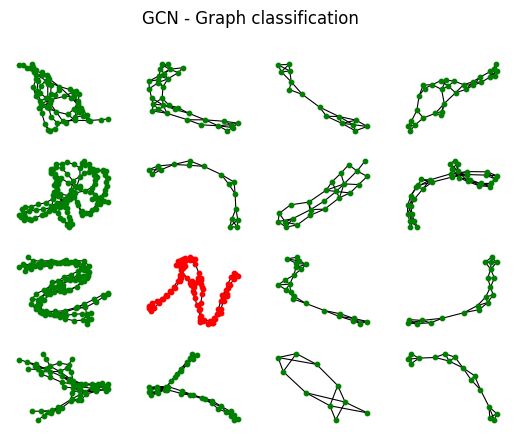

In [393]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4)
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

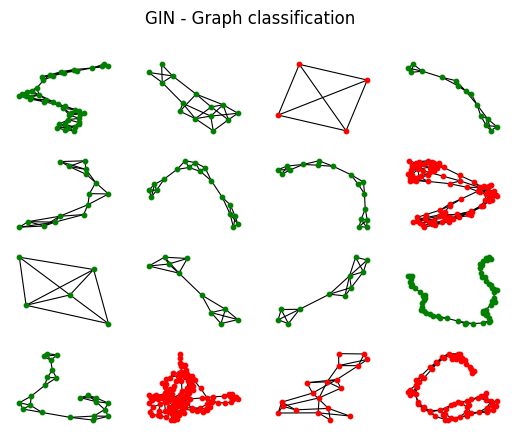

In [59]:
fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

In [154]:
gcn.eval()
gin.eval()
gat.eval()
acc_gcn = 0
acc_gin = 0
acc_ens = 0
acc_gat = 0

for data in test_loader:
    # Get classifications
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_gat = gat(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)
    acc_gat += accuracy(out_gat.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')
print(f'GAT accuracy: {acc_gat*100:.2f}%')

GCN accuracy:     69.01%
GIN accuracy:     69.79%
GCN+GIN accuracy: 71.09%
GAT accuracy: 62.50%


# Signed Weighted Graphs

In [7]:
import pandas as pd
from glob import glob

In [10]:
import sys

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import dgl
#from dgl.nn.pytorch import JumpingKnowledge, SAGEConv, SortPooling
#import dgl.function as fn
#from dgl.nn.functional import edge_softmax
import torchmetrics.classification as tc
import pandas as pd
import numpy as np
import csv

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [16]:
from os.path import join

In [22]:
directory = 'signed_weighted_graph_classification'
file1 = 'Graph_ctrl_crc1.csv'
file2 = 'Graph_case_crc1.csv'

In [76]:
!mkdir test_data_dir
%cd test_data_dir
!wget https://media.githubusercontent.com/media/panshuheng/WSGMB/refs/heads/master/Graph_ctrl_crc1.csv
!wget https://media.githubusercontent.com/media/panshuheng/WSGMB/refs/heads/master/Graph_ctrl_crc2.csv
!wget https://media.githubusercontent.com/media/panshuheng/WSGMB/refs/heads/master/Graph_ctrl_crc3.csv
!wget https://media.githubusercontent.com/media/panshuheng/WSGMB/refs/heads/master/Graph_case_crc1.csv
!wget https://media.githubusercontent.com/media/panshuheng/WSGMB/refs/heads/master/Graph_case_crc2.csv
!wget https://media.githubusercontent.com/media/panshuheng/WSGMB/refs/heads/master/Graph_case_crc3.csv

In [423]:
def get_data(csv_path, label):
    df = pd.read_csv(csv_path)
    grouped = df.groupby('graph_id').agg({'source':list, 'target':list,'weight':list})
    
    res = []
    for i, row in grouped.iterrows():
        edge_index = torch.Tensor([row['source'], row['target']]).to(torch.int64)
        edge_weight =torch.Tensor(row['weight'])
        num_nodes = len(set(row['source']+row['target']))
        y = label
        x = torch.ones(size=(num_nodes,1))
        # x = torch.arange(num_nodes)
        data = Data(x=x, edge_index=edge_index, y=y)
        
        #data.num_nodes = num_nodes
        data.edge_weight = edge_weight
        res.append(data)
    return res

In [424]:
def get_all_graphs(paths):
        data_list = []
        idx = 0
        
        for path in paths:
            data_list += get_data(path, idx)
            idx +=1
        
        return data_list

In [425]:
paths = ['signed_weighted_graph_classification/Graph_ctrl_crc1.csv',
         'signed_weighted_graph_classification/Graph_case_crc1.csv' ]

In [426]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

data_list = get_all_graphs(paths)
                              
#loader = DataLoader(data_list, batch_size=32, shuffle=True)

In [467]:
train_dataset = data_list[:int(len(data_list)*0.8)]
val_dataset   = data_list[int(len(data_list)*0.8):int(len(data_list)*0.9)]
test_dataset  = data_list[int(len(data_list)*0.9):]


print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=True)

Training set   = 800 graphs
Validation set = 100 graphs
Test set       = 100 graphs


In [472]:
from torch_geometric.nn import RGATConv

class GATClassifier(torch.nn.Module):
    def __init__(self, in_dim, dim_h):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(in_dim, dim_h, heads=1)
        self.conv2 = GATConv(dim_h, dim_h, heads=1)
        self.conv3 = GATConv(dim_h, dim_h, heads=1)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index, edge_attr)
        h = h.relu()
        h = self.conv2(h, edge_index, edge_attr)
        h = h.relu()
        h = self.conv3(h, edge_index, edge_attr)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

In [473]:
class DirGATConv(torch.nn.Module):
    def __init__(self, input_dim, output_dim, heads, alpha):
        super(DirGATConv, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.conv_src_to_dst = GATConv(input_dim, output_dim, heads=heads)
        self.conv_dst_to_src = GATConv(input_dim, output_dim, heads=heads)
        self.alpha = alpha

    def forward(self, x, edge_index, edge_attr):
        edge_index_t = torch.stack([edge_index[1], edge_index[0]], dim=0)

        return (1 - self.alpha) * self.conv_src_to_dst(x, edge_index, edge_attr) + self.alpha * self.conv_dst_to_src(
            x, edge_index_t, edge_attr
        )

In [474]:
def train(model, loader,device):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader,device)

        # Print metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
            
    return model

In [475]:
@torch.no_grad()
def test(model, loader,device):
    criterion = torch.nn.NLLLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


In [476]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gat = GATClassifier(in_dim = 1, dim_h=32)
gat = gat.to(device)

gat = train(gat, train_loader, device)
test_loss, test_acc = test(gat, test_loader, device)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.67 | Train Acc: 61.25% | Val Loss: 0.92 | Val Acc: 0.00%
Epoch  20 | Train Loss: 0.66 | Train Acc: 62.50% | Val Loss: 1.00 | Val Acc: 0.00%
Epoch  40 | Train Loss: 0.66 | Train Acc: 62.50% | Val Loss: 0.97 | Val Acc: 0.00%
Epoch  60 | Train Loss: 0.66 | Train Acc: 62.50% | Val Loss: 0.97 | Val Acc: 0.00%
Epoch  80 | Train Loss: 0.67 | Train Acc: 62.50% | Val Loss: 0.98 | Val Acc: 0.00%
Epoch 100 | Train Loss: 0.66 | Train Acc: 62.50% | Val Loss: 1.05 | Val Acc: 0.00%
Test Loss: 1.05 | Test Acc: 0.00%
